In [1]:
#Importing the required libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML,display

warnings.filterwarnings("ignore")

In [2]:
#Read the daily city-wise data
df= pd.read_csv("./air-quality-dataset/city_day.csv",parse_dates=True)
df['Date'] = pd.to_datetime(df['Date'])

In [3]:
#Keeping only the columns needed
df=df[['City','Date','AQI']]

In [4]:
#Filtering the dataframe to keep the data for the city of Delhi only
delhi = df[df['City'] == 'Delhi']
delhi.drop(['City'],axis=1,inplace = True)
delhi.set_index('Date', inplace = True)


In [5]:
delhi

,AQI
Date,
2015-01-01,472.0
2015-01-02,454.0
2015-01-03,143.0
2015-01-04,319.0
2015-01-05,325.0
...,...
2020-06-27,112.0
2020-06-28,196.0
2020-06-29,233.0


In [6]:
#Fill NULL DATA
delhi['AQI'].fillna(method = 'bfill',inplace = True)

In [7]:
#Taking monthly average
delhi=delhi.astype('float64')
delhi=delhi.resample(rule='MS').mean()

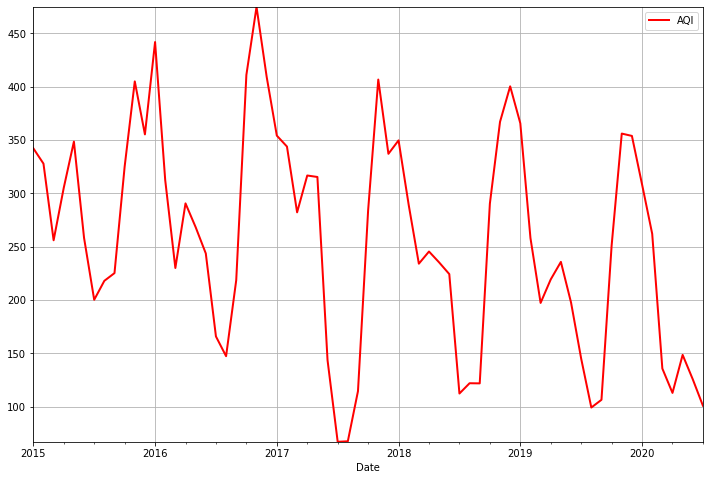

In [8]:
ax=delhi[['AQI']].plot(figsize=(12,8),grid=True,lw=2,color='Red')
ax.autoscale(enable=True, axis='both', tight=True)

# FORECASTING


In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

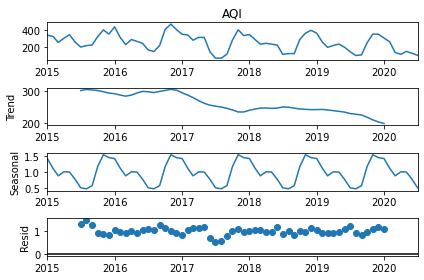

In [10]:
delhi_AQI=delhi['AQI']
result=seasonal_decompose(delhi_AQI,model='multiplicative')
result.plot();

# **SARIMAX MODEL**

In [11]:
#Importing the SARIMAX Model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [12]:
len(delhi_AQI)

67

In [ ]:
#Splitting the training and testing dataset
train=delhi_AQI[:48]
test=delhi_AQI[48:61]

In [ ]:
#Defining our model and fitting on the training data
model=SARIMAX(train,order=(0,1,3),seasonal_order=(0,1,1,12))
results=model.fit()
results.summary()

In [ ]:
#Predicting on our train and test dataset
train_predictions = results.predict(start=1, end=48, typ='levels').rename('Predictions')
test_predictions = results.predict(start=48, end=60, typ='levels').rename('Predictions')

In [ ]:
#Plotting the train predictions to see the fit of the model
train_predictions.plot(legend=True)
train.plot(legend=True)

In [ ]:
#Calculating the RMSE value on the training dataset 
RMSE=np.sqrt(mean_squared_error(train_predictions,train))
print('RMSE = ',RMSE)
print('Mean AQI',train.mean())

In [ ]:
#Plotting the test predictions to see how well our model generalized
test_predictions.plot(legend=True)
test.plot(legend=True)

In [ ]:
#Calculating the RMSE value on the testing dataset 
RMSE=np.sqrt(mean_squared_error(test_predictions,test))
print('RMSE = ',RMSE)
print('Mean AQI',test.mean())

In [ ]:
#Obtaining predicted values:
future_predictions = results.predict(start=67, end=77, typ='levels').rename('Predictions')

#Plotting predicted values against the true values:
future_predictions.plot(legend=True)
delhi_AQI.plot(legend=True,figsize=(12,8),grid=True)

### GRID search framework for fine tuning the model

In [ ]:
def grid_search(p,d,q,P,D,Q,m,train,test):
    
    column_names = ['p','d','q','P','D','Q','m','RMSE_train','RMSE_test']
    df = pd.DataFrame(columns = column_names)

    for p1 in p:
        for p2 in d:
            for p3 in q:
                for p4 in P:
                    for p5 in D:
                        for p6 in Q:
                            for p7 in m:
                                
                                
                                model=SARIMAX(train,order=(p1,p2,p3),seasonal_order=(p4,p5,p6,p7))
                                try:
                                    results=model.fit()
                                except:
                                    print("Passing on : " + str(p1) + " " + str(p2) + " " + str(p3) + " " + str(p4) + " " + str(p5) + " " + str(p6) + " " + str(p7))
                                    pass
                                print("Fitting on : " + str(p1) + " " + str(p2) + " " + str(p3) + " " + str(p4) + " " + str(p5) + " " + str(p6) + " " + str(p7))
                                #results.summary()
                                #Predicting on our train and test dataset
                                train_predictions = results.predict(start=1, end=48, typ='levels').rename('Predictions')
                                test_predictions = results.predict(start=48, end=60, typ='levels').rename('Predictions')
                                
                                #Calculating the RMSE value on the training dataset 
                                RMSE_train = np.sqrt(mean_squared_error(train_predictions,train))
                                #Calculating the RMSE value on the testing dataset 
                                RMSE_test=np.sqrt(mean_squared_error(test_predictions,test))
                                
                                #Fill our dataframe
                                df = df.append({'p':p1, 'd':p2,'q':p3,
                                                'P':p4,'D':p5,'Q':p6,'m':p7,
                                                'RMSE_train' : RMSE_train, 'RMSE_test' : RMSE_test},
                                               ignore_index = True)
                                print(df.tail(1))
                                
                                
                                
    return df

In [ ]:
train=delhi_AQI[:48]
test=delhi_AQI[48:61]

p = [1,2,3,0]
d = [1,2,3,0]
q = [1,2,3,0]
P = [1,2,3,0]
D = [1,2,3,0]
Q = [1,2,3,0]
m = [12]

table = grid_search(p,d,q,P,D,Q,m,train,test)

In [ ]:
table

In [ ]:
table.to_csv("grid-search-results.csv")